<img src="http://hilpisch.com/tpq_logo.png" width="350px" align="right">

# FPQ Bootcamp

**DAY 03 &mdash; Session 01**

Dr. Yves J. Hilpisch

The Python Quants GmbH

## The Imports

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

data_url = 'http://hilpisch.com/tr_eikon_eod_data.csv'

raw = pd.read_csv(data_url, index_col=0, parse_dates=True)

raw.dropna(inplace=True)

In [2]:
symbol = 'EUR='

In [3]:
data = pd.DataFrame(raw[symbol])

In [4]:
#data.info()

In [5]:
#data.plot(figsize=(10, 6));

In [6]:
data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))

In [7]:
data.dropna(inplace=True)

In [8]:
data['Direction'] = np.sign(data['Returns'])

## Classification-based Prediction with ML

In [9]:
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [10]:
lags = 5

In [11]:
mu = data['Returns'].mean()
std = data['Returns'].std()

In [12]:
cols = []
for lag in range(3, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['Returns'].shift(lag)
    cols.append(col)

In [13]:
data.dropna(inplace=True)

In [14]:
# this bit is setting up classification bins that represent patterns the model can learn from. 
# originall there were 32 patterns, now with the bins and the limits on them we have 1024 bins, which is way bigger for the 
# model to train against
bins = [mu - std, mu, mu + std]
data[cols] = np.digitize(data[cols], bins=bins)

In [15]:
model = linear_model.LogisticRegression(C=1, solver='lbfgs', multi_class='auto')
model = linear_model.LogisticRegression(C=100, solver='lbfgs', multi_class='auto')
model = SVC(C=1, kernel='rbf',gamma='auto')
model = linear_model.LogisticRegression(C=1, solver='lbfgs', multi_class='auto')
model=MLPClassifier(hidden_layer_sizes=[100,100], max_iter=1000)

In [16]:
model.fit(data[cols], data['Direction'])
model.fit(data[cols], data['Direction'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[100, 100], learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [17]:
data['Position'] = model.predict(data[cols])

In [18]:
data.head()

,EUR=,Returns,Direction,lag_3,lag_4,lag_5,Position
Date,,,,,,,
2010-01-12,1.4494,-0.001310,-1.0,0.0,2.0,1.0,1.0
2010-01-13,1.4510,0.001103,1.0,3.0,0.0,2.0,-1.0
2010-01-14,1.4502,-0.000551,-1.0,3.0,3.0,0.0,-1.0
2010-01-15,1.4382,-0.008309,-1.0,1.0,3.0,3.0,-1.0
2010-01-19,1.4298,-0.005858,-1.0,2.0,1.0,3.0,-1.0


In [19]:
accuracy_score(data['Position'], data['Direction'])

0.5637898686679175

### backtests

In [20]:
data['Strategy'] = data['Position'] * data['Returns']

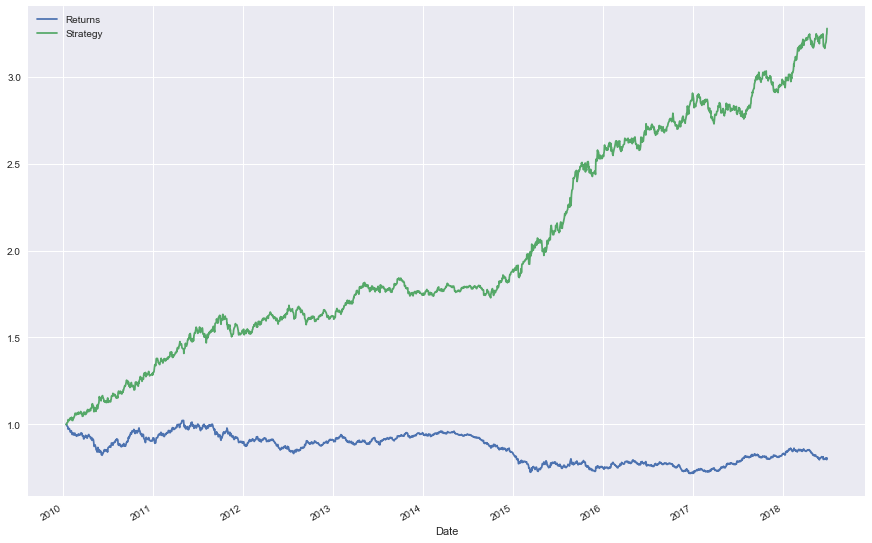

In [21]:
data[['Returns','Strategy']].cumsum().apply(np.exp).plot(figsize=(15,10))

## Train-Test Split

### Sequential Train-Test Split

In [22]:
split = int(len(data) * 0.7)
split

1492

In [23]:
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [24]:
model.fit(train[cols], train['Direction'])


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[100, 100], learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [25]:
test['Position'] = model.predict(test[cols])


In [26]:
test['Strategy'] = test['Position'] * test['Returns']


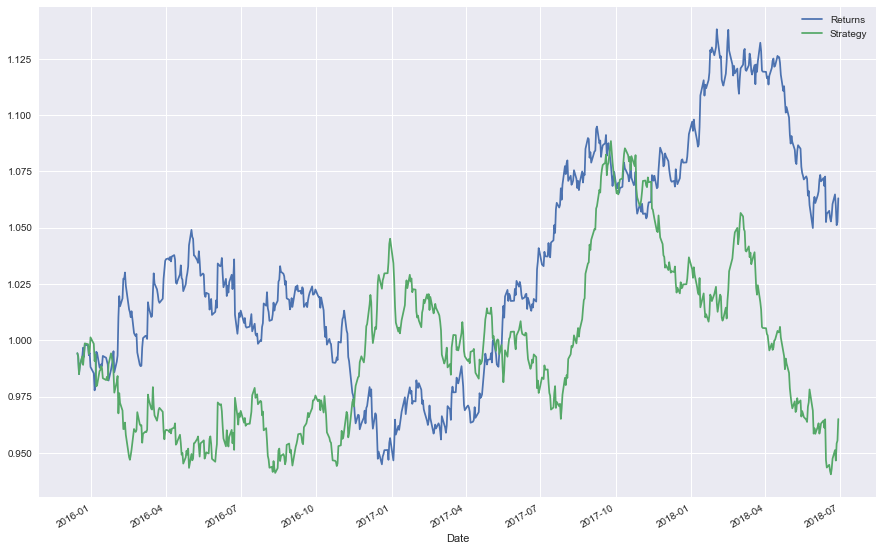

In [27]:
test[['Returns', 'Strategy']].cumsum(
            ).apply(np.exp).plot(figsize=(15, 10));

### Cross Validation

In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
cross_val_score(model, data[cols], data['Direction'], cv=3)

array([0.47398031, 0.49507736, 0.51549296])

### Randomized Split

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
# train_test_split?

In [32]:
train_x, test_x, train_y, test_y = train_test_split(
            data, data['Direction'], test_size=0.7, random_state=200)

In [33]:
train_x[cols].head()

,lag_3,lag_4,lag_5
Date,,,
2012-04-27,2.0,1.0,3.0
2017-04-27,3.0,2.0,2.0
2011-03-22,3.0,0.0,2.0
2012-02-01,3.0,1.0,3.0
2015-05-20,2.0,2.0,3.0


In [34]:
train_x = train_x.sort_index().copy()
test_x = test_x.sort_index().copy()
train_y = train_y.sort_index().copy()
test_y = test_y.sort_index().copy()

In [35]:
model.fit(train_x[cols], train_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[100, 100], learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [36]:
results = pd.DataFrame()

In [37]:
results['Returns'] = test_x['Returns']

In [38]:
results['Position'] = model.predict(test_x[cols])


In [39]:
results['Strategy'] = results['Position'] * test_x['Returns']


In [40]:
results.head()

,Returns,Position,Strategy
Date,,,
2010-01-12,-0.001310,1.0,-0.001310
2010-01-13,0.001103,-1.0,-0.001103
2010-01-15,-0.008309,1.0,-0.008309
2010-01-19,-0.005858,-1.0,0.005858
2010-01-20,-0.013874,1.0,-0.013874


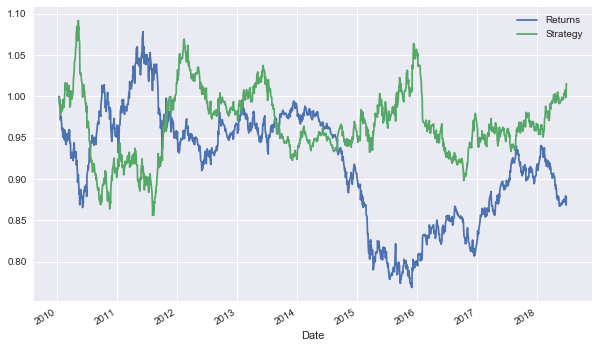

In [41]:
results[['Returns', 'Strategy']].cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

## <img src="http://hilpisch.com/tpq_logo.png" width="350px" align="right">